<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
# Import Libraries

import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score,  roc_auc_score, roc_curve, classification_report
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder

%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
# Suppress annoying harmless error.
warnings.simplefilter('ignore')


Using TensorFlow backend.


In [3]:
demographics=pd.read_pickle("./clean_demograph.pkl")

In [5]:
demographics.head()

,Sex,Age,Family Income,Life Cycle,Education,Race,Home Ownership,City,HH Size,HH Vehicles,HH Drivers,HH Workers,Urban,Primary Activity,Worker Status,BEV,Vehicle Age,Annual Miles
0,1,0.887915,0.303329,9,2,1,0,33,0.208147,2.234702,1.249077,-0.326856,0,5,1,0,1.809396,-0.658035
2,0,0.840311,0.303329,9,2,1,0,33,0.208147,2.234702,1.249077,-0.326856,0,0,0,0,2.656992,0.094797
4,1,-0.968652,0.303329,9,1,1,0,33,0.208147,2.234702,1.249077,-0.326856,0,4,1,0,0.283723,-0.649762
6,0,0.316664,0.843135,1,4,0,0,49,-0.527457,1.380636,-0.043644,0.705862,3,0,0,0,0.792281,0.094797
8,1,-0.159379,2.192652,0,4,0,0,32,-1.263062,-0.327497,-1.336366,-0.326856,0,0,0,0,0.792281,-0.236118


In [6]:
y = demographics.BEV
X = demographics.drop(['BEV'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [7]:
df = pd.concat([X_train, y_train], axis=1)
bought = df[df.BEV==1]
didntbuy = df[df.BEV==0]

downsample = resample(didntbuy,replace = False, n_samples = len(bought)) 
downsampled = pd.concat([downsample, bought])

y_train = downsampled['BEV']
X_train = downsampled.drop('BEV',axis=1)

In [11]:
def model_results(model, y_pred):
    print('Train set score:\t\t', round(model.score(X_train, y_train),2))
    print('Best cross validation score:\t', round(model.best_score_,2))
    print('Test set score:\t\t\t', round(model.score(X_test, y_test),2))
    print('Report:')
    print(classification_report(y_test, y_pred))
    conf_mat = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_mat,annot=True, cbar=True, fmt='d',cmap='mako_r')
    plt.show()

Train set score:		 1.0
Best cross validation score:	 0.91
Test set score:			 0.92
Report:
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     51801
           1       0.01      0.87      0.03       152

    accuracy                           0.82     51953
   macro avg       0.51      0.84      0.46     51953
weighted avg       1.00      0.82      0.90     51953



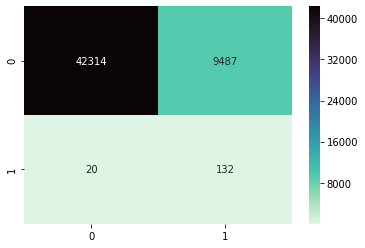

In [12]:
results=pd.DataFrame()
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
pipe1 = imbPipeline([
    ('oversample', SMOTE(random_state=0)),
    ('rfc', RandomForestClassifier(random_state=27, n_jobs=-1))
    ])

param_grid = {'rfc__max_depth': [20, 50, 100],
              'rfc__max_features': ['auto'],
              'rfc__min_samples_leaf': [1, 2],
              'rfc__min_samples_split': [2, 3],
              'rfc__n_estimators': [10, 50, 100],
              'rfc__criterion': ['gini', 'entropy']}
grid_rfc = GridSearchCV(pipe1, param_grid, return_train_score=False,
                    n_jobs=-1, cv=5, scoring='roc_auc')
grid_rfc.fit(X_train, y_train)

#Store results
y_pred_proba = grid_rfc.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
results.loc[0, :] = [grid_rfc.score(X_test, y_test), fpr, tpr]

# Print results
y_pred = grid_rfc.predict(X_test)
model_results(grid_rfc, y_pred)

Train set score:		 0.88
Best cross validation score:	 0.86
Test set score:			 0.85
Report:
              precision    recall  f1-score   support

           0       1.00      0.76      0.87     51801
           1       0.01      0.79      0.02       152

    accuracy                           0.76     51953
   macro avg       0.50      0.78      0.44     51953
weighted avg       1.00      0.76      0.86     51953



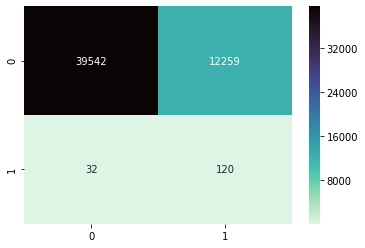

In [13]:
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.model_selection import StratifiedKFold
pipe4 = imbPipeline([
    ('oversample', SMOTE(random_state=0)),
    ('lr', LogisticRegression(random_state=27))
    ])

param_grid = {'lr__C': [.1, 1, 10],
              'lr__penalty': ['l2', 'l1']} #, 
grid_lr = GridSearchCV(pipe4, param_grid, return_train_score=False,
                    n_jobs=-1, cv=5, scoring='roc_auc')
grid_lr.fit(X_train, y_train)

#Store results
y_pred_proba = grid_lr.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
results.loc[3, :] = [grid_lr.score(X_test, y_test), fpr, tpr]

# Print results
y_pred = grid_lr.predict(X_test)
model_results(grid_lr, y_pred)

In [24]:
grid_rfc.best_estimator_[1]

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=100, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=27, verbose=0,
                       warm_start=False)

Text(0.5, 0, 'Relative Importance')

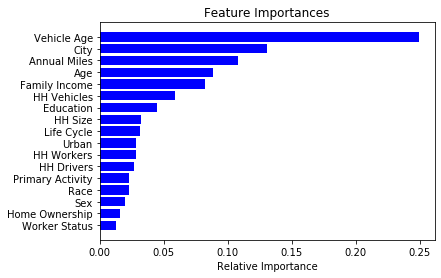

In [28]:
rfc = RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='entropy', max_depth=100,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=3,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=-1,
                                        oob_score=False, random_state=27,
                                        verbose=0, warm_start=False)
rfc.fit(X_train, y_train) 
pred_rfc =rfc.predict(X_test) 

features=X_train.columns
importances = rfc.feature_importances_
indices = np.argsort(importances)

plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

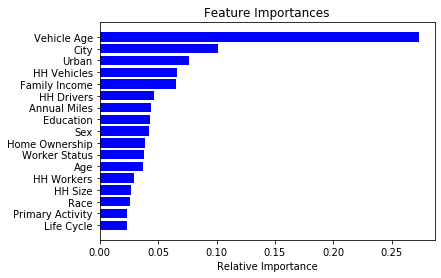

In [30]:
xgb = XGBClassifier()
xgb.fit(X_train,y_train)

importances = xgb.feature_importances_
indices = np.argsort(importances)

plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()